In [2]:
print('hello')

hello


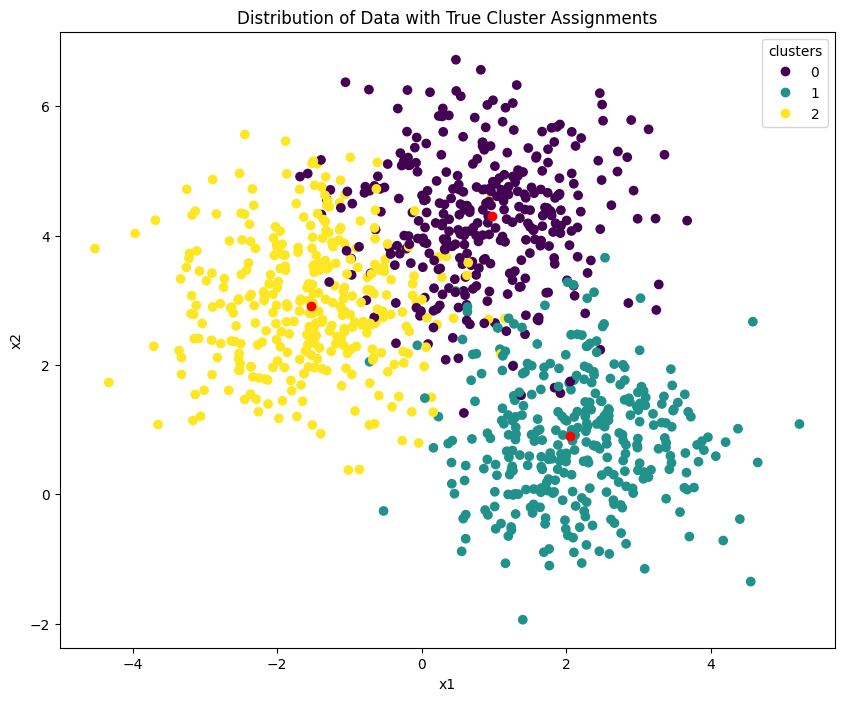

In [3]:
# imports
import numpy as np
from typing import Tuple, Dict
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, \
                            accuracy_score, \
                            precision_score, \
                            recall_score, \
                            f1_score

# Membuat Algoritma kMeans
class KMeans(object):
    """
    Class to encapsulate the K-Means algorithm
    """
    def __init__(self, K: int=3, n_init: int=20, max_iters: int=100) -> None:
        """
        Initialiser function for a class instance
        Inputs:
        K -> integer number of clusters to assign
        n_init -> integer number of times the algorithm will be applied when training
        max_iters -> maximum number of iterations the algorithm is allowed
        to run before stopping
        """
        if K <= 0:
            raise ValueError(f'K must be a positive integer, got: {K}')
        if n_init <= 0:
            raise ValueError(f'n_init must be a positive integer, got: {n_init}')
        if max_iters <= 0:
            raise ValueError(f'Input argument max_iters must be a positive integer, got: {max_iters}')
        
        self.K = K
        self.n_init = n_init
        self.centroids = np.array([])
        self.total_wcss = np.inf
        self.wcss_array = np.array([])
        self.max_iters = max_iters
        
    def __del__(self) -> None:
        """
        Destructor function for class instance
        """
        del self.K
        del self.n_init
        del self.centroids
        del self.total_wcss
        del self.wcss_array
        del self.max_iters
        
    def __assign_samples(self, X : np.array, centroids : np.array) -> np.array:
        """
        Private function to assign samples to clusters
        Inputs:
        X -> numpy array of input features with shape: [number_samples, number_features]
        centroids -> numpy array of centroids with shape: [K, number_features]
        Output: numpy array indicating cluster assignment per sample with shape:[number_samples,]
        """
        # compute difference between input features & centroids through broadcasting
        differences = X[:,np.newaxis] - centroids[np.newaxis]
        # compute the squared euclidean distance for every (number_samples, K) pairs
        euclid_dist = np.einsum('ijk,ijk->ij', differences, differences)
        # find minimal distance for each sample & return
        return np.argmin(euclid_dist, axis=1)

    def __partition_data(self, X : np.array, cluster_assignment : np.array) -> list:
        """
        Private function to partition input features according to cluster assignment
        Inputs:
        X -> numpy array of input features with shape: [number_samples, number_features]
        cluster_assignment -> numpy array of cluster assignments with shape: [number_samples,]
        Output: list of numpy arrays of centroid for cluster, each array with shape: [cluster_number_samples, number_features]
        """
        # join features and cluster assignment
        X_assigned = np.concatenate((X, cluster_assignment.reshape(-1,1)),axis=1)
        # sort on the cluster assignment
        X_assigned = X_assigned[X_assigned[:, -1].argsort()]
        # partition the data based on the cluster assignment & return
        return np.split(X_assigned[:,:-1], np.unique(X_assigned[:, -1], return_index=True)[1][1:])
    
    def __compute_wcss(self, X : np.array, cluster_assignment : np.array, centroids : np.array) -> Tuple[float, np.array]:
        """
        Private function to compute WCSS over all clusters
        Inputs:
        X -> numpy array of input features with shape: [number_samples, number_features]
        cluster_assignment -> numpy array of cluster assignments with shape: [number_samples,]
        centroids -> numpy array of centroids with shape: [K, number_features]
        Output:
        tuple containing the total WCSS, along with numpy array of WCSS values for clusters with shape: [K]
        """
        # break up the input features according to their cluster assignments
        X_clusters = self.__partition_data(X, cluster_assignment)
        # compute the WCSS for each cluster 
        wcss_array = np.array([np.einsum('ij,ij', X_clusters[i] - centroids[i,:], X_clusters[i] - centroids[i,:]) for i in range(self.K)])
        # return the WCSS per cluster, along with the sum over all clusters
        return (np.sum(wcss_array), wcss_array)
        
    def __update_centroids(self, X : np.array, cluster_assignment : np.array) -> np.array:
        """
        Private function to update cluster centroids
        Inputs:
        X -> numpy array of input features with shape: [number_samples, number_features]
        cluster_assignment -> numpy array of cluster assignments with shape:[number_samples,]
        Output: numpy array of centroids with shape: [K, number_features]
        """
        # break up the input features according to their cluster assignments
        X_clusters = self.__partition_data(X, cluster_assignment)
        # compute new centroids & return
        return np.array([np.mean(x, axis=0) for x in X_clusters])

    def fit(self, X : np.array) -> None:
        """
        Training function for the class. Aims to find the optimal centroid values that minimise the WCSS
        Inputs:
        X -> numpy array of input features of assumed shape [number_samples, number_features]
        """
        # initialise wcss score
        self.total_wcss = np.inf
        # loop over all iterations requested
        for _ in range(self.n_init):
        # initialise centroids
            centroids = X[np.random.choice(X.shape[0], self.K, replace=False)]
            old_centroids = np.copy(centroids)
            # loop through the K-Means learning algorithm
            centroid_diff = np.ones((self.K))
            iteration = 0
            while (not np.array_equal(centroid_diff,np.zeros(self.K))) and iteration < self.max_iters:
                # assign samples to clusters
                cluster_assignment = self.__assign_samples(X, centroids)
                # update centroids
                centroids = self.__update_centroids(X, cluster_assignment)
                # compute difference between centroids
                centroid_diff = np.abs(old_centroids - centroids)
                # increment counter & reset old_centroids
                iteration += 1
                old_centroids = np.copy(centroids)
            # compute WCSS for the resulting clusters
            total_wcss, wcss_array = self.__compute_wcss(X, cluster_assignment, centroids)
            # check if we have a new optimal centroid configuration?
            if total_wcss < self.total_wcss:
                # if so, update storage objects
                self.total_wcss = total_wcss
                self.wcss_array = wcss_array
                self.centroids = centroids
                
    def predict(self, X : np.array) -> None:
        """
        Predict function for the class. Assigns cluster labels to each sample based on proximity to centroids
        Input:
        X -> numpy array of input features of assumed shape [number_samples, number_features]
        Output: numpy array indicating cluster assignment per sample with shape: [number_samples,]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.__assign_samples(X, self.centroids)
        
    def return_wcss(self) -> Tuple[float, np.array]:
        """
        Public function to return WCSS scores (after training)
        Output: tuple containing the total WCSS, along with numpy array of WCSS values for clusters with shape: [K]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return (self.total_wcss, self.wcss_array)
        
    def return_centroids(self) -> np.array:
        """
        Public function to return centroids (after training)
        Output: numpy array containing the centroids with shape: [K, number_features]
        """
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.centroids
        
    def get_params(self, deep : bool = False) -> Dict:
        """
        Public function to return model parameters
        Inputs:
        deep -> boolean input parameter
        Outputs:
        Dict -> dictionary of stored class input parameters
        """
        return {'K':self.K, 
                'n_init':self.n_init, 
                'max_iters':self.max_iters}
        
# Memproduksi dataset
X, y, centers = make_blobs(n_samples=1000, centers=3, n_features=2, return_centers=True, random_state=0)
# visualise data
fig, ax = plt.subplots(figsize=(10,8))
sc = ax.scatter(X[:,0],X[:,1],c=y)
sc_centers = ax.scatter(centers[:,0],centers[:,1],c='r')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribution of Data with True Cluster Assignments')
ax.legend(*sc.legend_elements(), title='clusters')
plt.show()

In [4]:
type(X)

numpy.ndarray

In [5]:
print(X)

[[-0.80723584  2.66946295]
 [ 1.9263585   4.15243012]
 [-1.50016563  3.10133251]
 ...
 [ 0.41230223  0.49159186]
 [-2.53294087  2.09633244]
 [ 1.10777893  1.14210712]]


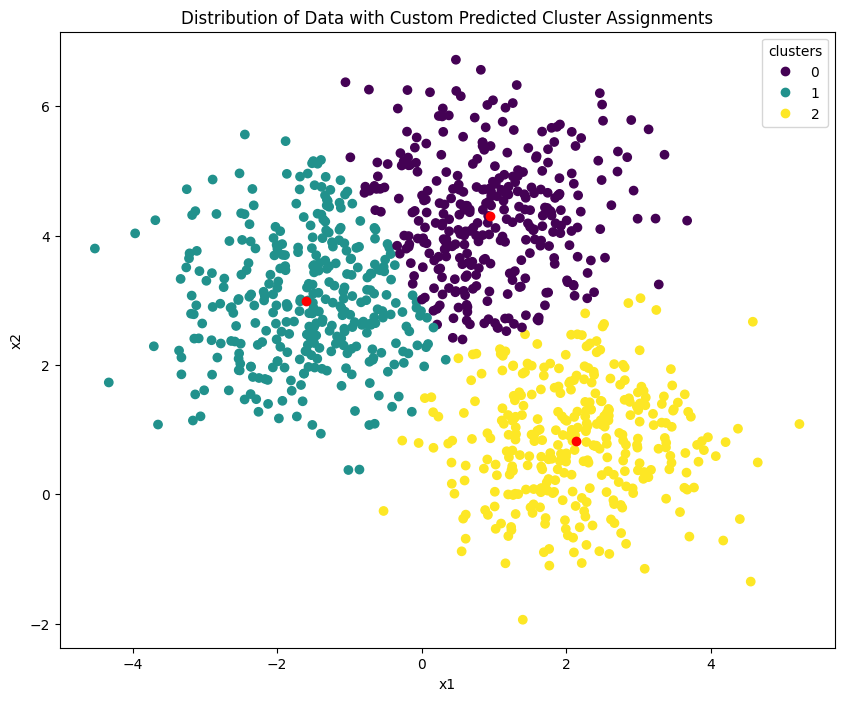

In [6]:
# Buat model KMeans
clt = KMeans(max_iters=300)
# Cocokkan model dengan data
clt.fit(X)
# Dapatkan prediksi
y_pred = clt.predict(X)
# Dapatkan prediksi sentroid
centers_pred = clt.return_centroids()
# Visualisasikan prediksi
fig, ax = plt.subplots(figsize=(10,8))
sc = ax.scatter(X[:,0],X[:,1],c=y_pred)
sc_centers = ax.scatter(centers_pred[:,0],centers_pred[:,1],c='r')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribution of Data with Custom Predicted Cluster Assignments')
ax.legend(*sc.legend_elements(), title='clusters')
plt.show()

In [7]:
# Mendapatkan nilai cluster errors
clt.return_wcss()
# Seberapa akurat estimasi sentroid yang dihasilkan?
print(f'The mean absolute error between the predicted and true centroids is: {mean_absolute_error(centers,centers_pred[[2,0,1]])}')
# Kalibrasikan pelabelan (if needed)
idx_0 = y_pred == 0
idx_1 = y_pred == 1
idx_2 = y_pred == 2
y_pred[idx_0] = 2
y_pred[idx_1] = 0
y_pred[idx_2] = 1
# Seberapa akurat penempatan klasterisasi yang dihasilkan?
acc = accuracy_score(y,y_pred)
pre = precision_score(y,y_pred,average='weighted')
rec = recall_score(y,y_pred,average='weighted')
f1 = f1_score(y,y_pred,average='weighted')
print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')


The mean absolute error between the predicted and true centroids is: 1.5498465790273377
Accuracy score: 0.3640
Precision score: 0.3638
Recall score: 0.3640
F1 score: 0.3639


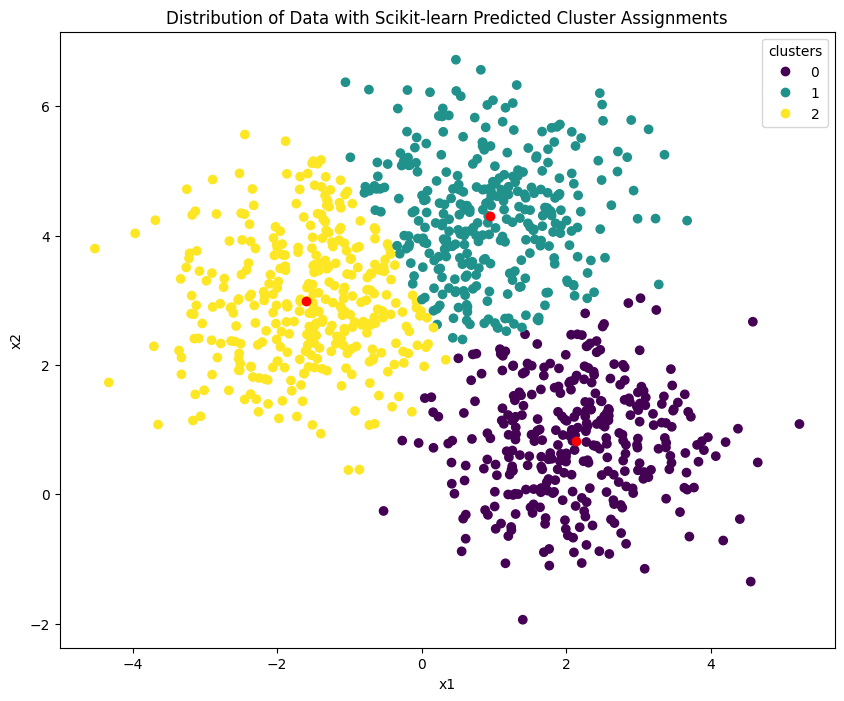

In [8]:
# import scikit-learn K-Means
from sklearn.cluster import KMeans
# Buat model KMeans
clt = KMeans(n_clusters=3, max_iter=300, random_state=0)
# Cocokkan model dengan data
clt.fit(X)
# Dapatkan prediksi
y_pred = clt.predict(X)
# Dapatkan prediksi sentroid
centers_pred = clt.cluster_centers_
# Visualisasikan prediksi
fig, ax = plt.subplots(figsize=(10,8))
sc = ax.scatter(X[:,0],X[:,1],c=y_pred)
sc_centers = ax.scatter(centers_pred[:,0],centers_pred[:,1],c='r')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Distribution of Data with Scikit-learn Predicted Cluster Assignments')
ax.legend(*sc.legend_elements(), title='clusters')
plt.show()

In [9]:
# Seberapa akurat estimasi sentroid yang dihasilkan?
print(f'The mean absolute error between the predicted and true centroids is: {mean_absolute_error(centers,centers_pred[[1,0,2]])}')
# Kalibrasikan pelabelan (if needed)
idx_0 = y_pred == 0
idx_1 = y_pred == 1
idx_2 = y_pred == 2
y_pred[idx_0] = 1
y_pred[idx_1] = 0
y_pred[idx_2] = 2
# Seberapa akurat penempatan klasterisasi yang dihasilkan?
acc = accuracy_score(y,y_pred)
pre = precision_score(y,y_pred,average='weighted')
rec = recall_score(y,y_pred,average='weighted')
f1 = f1_score(y,y_pred,average='weighted')
print(f'Accuracy score: {acc:.4f}')
print(f'Precision score: {pre:.4f}')
print(f'Recall score: {rec:.4f}')
print(f'F1 score: {f1:.4f}')

The mean absolute error between the predicted and true centroids is: 0.05720900868245904
Accuracy score: 0.9180
Precision score: 0.9179
Recall score: 0.9180
F1 score: 0.9179


In [10]:
import pandas as pd
df = pd.read_csv('C:/Users/Thinkpad/Documents/ml_prak/Tugas_MLprak_tm9/air+quality/AirQualityUCI.csv')
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360,150,"11,9",1046,166,1056,113,1692,1268,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292,112,"9,4",955,103,1174,92,1559,972,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402,88,"9,0",939,131,1140,114,1555,1074,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376,80,"9,2",948,172,1092,122,1584,1203,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272,51,"6,5",836,131,1205,116,1490,1110,"11,2","59,6","0,7888"


In [11]:
for col in df.columns:
    print(f'{col} mempunyai value unik: {df[col].unique()}')
    print(f'{col} mempunyai total bilangan NaN: {df[col].isnull().sum()}')
    print('\n')

Date mempunyai value unik: ['10/03/2004' '11/03/2004' '12/03/2004' '13/03/2004' '14/03/2004'
 '15/03/2004' '16/03/2004' '17/03/2004' '18/03/2004' '19/03/2004'
 '20/03/2004' '21/03/2004' '22/03/2004' '23/03/2004' '24/03/2004'
 '25/03/2004' '26/03/2004' '27/03/2004' '28/03/2004' '29/03/2004'
 '30/03/2004' '31/03/2004' '01/04/2004' '02/04/2004' '03/04/2004'
 '04/04/2004' '05/04/2004' '06/04/2004' '07/04/2004' '08/04/2004'
 '09/04/2004' '10/04/2004' '11/04/2004' '12/04/2004' '13/04/2004'
 '14/04/2004' '15/04/2004' '16/04/2004' '17/04/2004' '18/04/2004'
 '19/04/2004' '20/04/2004' '21/04/2004' '22/04/2004' '23/04/2004'
 '24/04/2004' '25/04/2004' '26/04/2004' '27/04/2004' '28/04/2004'
 '29/04/2004' '30/04/2004' '01/05/2004' '02/05/2004' '03/05/2004'
 '04/05/2004' '05/05/2004' '06/05/2004' '07/05/2004' '08/05/2004'
 '09/05/2004' '10/05/2004' '11/05/2004' '12/05/2004' '13/05/2004'
 '14/05/2004' '15/05/2004' '16/05/2004' '17/05/2004' '18/05/2004'
 '19/05/2004' '20/05/2004' '21/05/2004' '22/05/20

In [12]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

In [13]:
df = df.drop(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)',
               'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
               'PT08.S5(O3)', 'T', 'AH'], axis=1)

In [14]:
df.head()

,NMHC(GT),RH
0,150,"48,9"
1,112,"47,7"
2,88,"54,0"
3,80,"60,0"
4,51,"59,6"


In [17]:
# Convert to NumPy array and ensure it is 2D
NMHC_array = df['NMHC(GT)'].to_numpy().reshape(-1, 1)  # Shape (n_samples, 1)
df['RH'] = df['RH'].replace(',', '.', regex=True).astype(float)

RH_array = df['RH'].to_numpy().reshape(-1, 1)  # Shape (n_samples, 1)

In [18]:
type(NMHC_array)

numpy.ndarray

In [19]:
print(NMHC_array.shape)

(9357, 1)


In [20]:
type(RH_array)

numpy.ndarray

In [32]:
print(RH_array.shape)

(9357, 1)


Starting training with 20 initializations...
Initialization 1/20: Converged at iteration 4
Initialization 1/20: WCSS = 0.00
Initialization 2/20: Converged at iteration 4
Initialization 2/20: WCSS = 0.00
Initialization 3/20: Converged at iteration 3
Initialization 3/20: WCSS = 0.00
Initialization 4/20: Converged at iteration 6
Initialization 4/20: WCSS = 0.00
Initialization 5/20: Converged at iteration 4
Initialization 5/20: WCSS = 0.00
Initialization 6/20: Converged at iteration 3
Initialization 6/20: WCSS = 1871.50
Initialization 7/20: Converged at iteration 4
Initialization 7/20: WCSS = 0.00
Initialization 8/20: Converged at iteration 3
Initialization 8/20: WCSS = 0.00
Initialization 9/20: Converged at iteration 4
Initialization 9/20: WCSS = 0.00
Initialization 10/20: Converged at iteration 2
Initialization 10/20: WCSS = 1872.00
Initialization 11/20: Converged at iteration 3
Initialization 11/20: WCSS = 0.00
Initialization 12/20: Converged at iteration 6
Initialization 12/20: WCSS = 

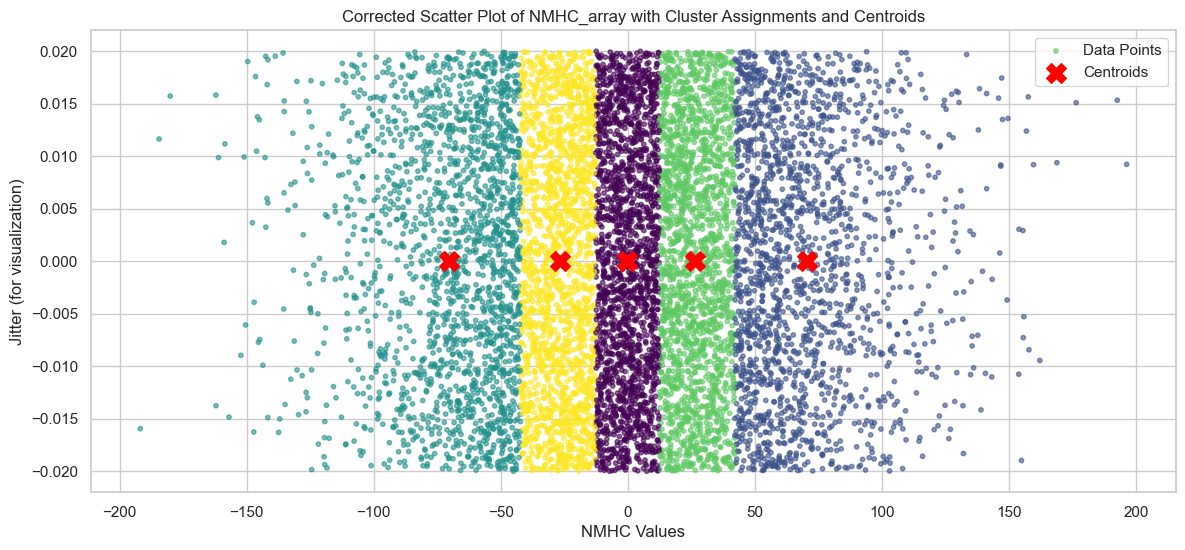


Evaluation Metrics:
Mean Absolute Error (MAE): 0.0000
Accuracy: 1.0000
Precision Score: 1.0000
Recall Score: 1.0000
F1 Score: 1.0000


In [31]:
import numpy as np
from typing import Tuple, Dict
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Your KMeans_AIR Class
# =========================
class KMeans_AIR(object):
    def __init__(self, K: int=5, n_init: int=20, max_iters: int=300) -> None:
        if K <= 0:
            raise ValueError(f'K must be a positive integer, got: {K}')
        if n_init <= 0:
            raise ValueError(f'n_init must be a positive integer, got: {n_init}')
        if max_iters <= 0:
            raise ValueError(f'Input argument max_iters must be a positive integer, got: {max_iters}')
        
        self.K = K
        self.n_init = n_init
        self.centroids = np.array([])
        self.total_wcss = np.inf
        self.wcss_array = np.array([])
        self.max_iters = max_iters
        
    def __assign_samples(self, X: np.array, centroids: np.array) -> np.array:
        differences = X[:, np.newaxis, :] - centroids[np.newaxis, :, :]
        euclid_dist = np.einsum('ijk,ijk->ij', differences, differences)
        return np.argmin(euclid_dist, axis=1)

    def __partition_data(self, X: np.array, cluster_assignment: np.array) -> list:
        clusters = []
        for k in range(self.K):
            mask = cluster_assignment == k
            cluster_points = X[mask]
            clusters.append(cluster_points)
        return clusters
    
    def __compute_wcss(self, X: np.array, cluster_assignment: np.array, centroids: np.array) -> Tuple[float, np.array]:
        wcss_array = np.zeros(self.K)
        for k in range(self.K):
            mask = cluster_assignment == k
            if np.sum(mask) > 0:
                cluster_points = X[mask]
                wcss_array[k] = np.sum((cluster_points - centroids[k]) ** 2)
        return np.sum(wcss_array), wcss_array
        
    def __update_centroids(self, X: np.array, cluster_assignment: np.array) -> np.array:
        new_centroids = np.zeros((self.K, X.shape[1]))
        for k in range(self.K):
            mask = cluster_assignment == k
            if np.sum(mask) > 0:
                new_centroids[k] = np.mean(X[mask], axis=0)
            else:
                new_centroids[k] = X[np.random.choice(X.shape[0])]
        return new_centroids

    def fit(self, X: np.array) -> None:
        print(f"Starting training with {self.n_init} initializations...")
        self.total_wcss = np.inf
        best_centroids = None
        
        for init in range(self.n_init):
            centroids = X[np.random.choice(X.shape[0], self.K, replace=False)]
            old_centroids = np.copy(centroids)
            
            for iteration in range(self.max_iters):
                cluster_assignment = self.__assign_samples(X, centroids)
                centroids = self.__update_centroids(X, cluster_assignment)
                
                if np.allclose(old_centroids, centroids):
                    print(f"Initialization {init + 1}/{self.n_init}: Converged at iteration {iteration + 1}")
                    break
                old_centroids = np.copy(centroids)
            
            total_wcss, wcss_array = self.__compute_wcss(X, cluster_assignment, centroids)
            print(f"Initialization {init + 1}/{self.n_init}: WCSS = {total_wcss:.2f}")
            
            if total_wcss < self.total_wcss:
                self.total_wcss = total_wcss
                self.wcss_array = wcss_array
                self.centroids = centroids
                
        if self.centroids.size == 0:
            raise Exception("Failed to find valid clustering solution!")
        
        print(f"Training completed. Final WCSS: {self.total_wcss:.2f}")
                
    def predict(self, X: np.array) -> np.array:
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.__assign_samples(X, self.centroids)
        
    def return_wcss(self) -> Tuple[float, np.array]:
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return (self.total_wcss, self.wcss_array)
        
    def return_centroids(self) -> np.array:
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.centroids
        
    def get_params(self, deep: bool = False) -> Dict:
        return {
            'K': self.K, 
            'n_init': self.n_init, 
            'max_iters': self.max_iters
        }

# =========================
# Data Preparation
# =========================

# Replace the synthetic data with your actual NMHC_array
# For demonstration, we'll create a synthetic NMHC_array similar to yours
np.random.seed(42)  # For reproducibility
NMHC_array = np.random.normal(loc=0, scale=50, size=(9357, 1))  # Replace with your actual data

# Flatten the array to shape (9357,) for easier processing
NMHC_flat = NMHC_array.flatten()

# Step 1: Define quintiles (20%, 40%, 60%, 80%) to split the data into 5 sections
quantiles = np.percentile(NMHC_flat, [20, 40, 60, 80])

# Function to assign quantile labels
def assign_quantiles(data, quantiles):
    labels = np.zeros(data.shape[0], dtype=int)
    labels[data > quantiles[3]] = 4  # Q5
    labels[(data > quantiles[2]) & (data <= quantiles[3])] = 3  # Q4
    labels[(data > quantiles[1]) & (data <= quantiles[2])] = 2  # Q3
    labels[(data > quantiles[0]) & (data <= quantiles[1])] = 1  # Q2
    labels[data <= quantiles[0]] = 0  # Q1
    return labels

# Assign labels based on quantiles
y = assign_quantiles(NMHC_flat, quantiles)

# Step 2: Create one-hot encoded features based on quantile labels
X = np.zeros((NMHC_flat.shape[0], 5))
X[np.arange(NMHC_flat.shape[0]), y] = 1

# =========================
# K-Means Clustering
# =========================

# Initialize and fit the KMeans_AIR model
kmeans = KMeans_AIR(K=5, n_init=20, max_iters=300)
kmeans.fit(X)

# Predict cluster assignments
cluster_labels = kmeans.predict(X)

# =========================
# Corrected Scatter Plot with Centroids
# =========================

# Step 1: Calculate Centroids in NMHC Value Space
centroid_values = []
for cluster in np.unique(cluster_labels):
    points_in_cluster = NMHC_flat[cluster_labels == cluster]
    if len(points_in_cluster) > 0:
        centroid_value = np.mean(points_in_cluster)  # Take the mean of NMHC values in this cluster
        centroid_values.append(centroid_value)
    else:
        centroid_values.append(np.nan)  # Handle empty clusters (if any)

# Convert the centroids list to a NumPy array for easy plotting
centroid_values = np.array(centroid_values)

# Step 2: Scatter Plot with Correct Centroid Positions
plt.figure(figsize=(14, 6))

# Add jitter to y-axis for better visualization of points
jitter_strength = 0.02
y_jitter = np.random.uniform(-jitter_strength, jitter_strength, size=NMHC_flat.shape[0])

# Scatter plot of NMHC values colored by cluster assignments
scatter = plt.scatter(NMHC_flat, y_jitter, c=cluster_labels, cmap='viridis', alpha=0.6, s=10, label='Data Points')

# Plot centroids on the x-axis (with y=0 for centroids)
plt.scatter(centroid_values, np.zeros_like(centroid_values), c='red', marker='X', s=200, label='Centroids')

# Add labels and title
plt.title('Corrected Scatter Plot of NMHC_array with Cluster Assignments and Centroids')
plt.xlabel('NMHC Values')
plt.ylabel('Jitter (for visualization)')
plt.legend(loc='upper right')

# Display the plot
plt.show()

# =========================
# Evaluation Metrics
# =========================

# Map clusters to quantile labels using Hungarian algorithm for optimal assignment
def map_clusters_to_labels(y_true, y_clusters):
    contingency_matrix = np.zeros((5, 5), dtype=int)
    for true_label in range(5):
        for cluster_label in range(5):
            contingency_matrix[true_label, cluster_label] = np.sum((y_true == true_label) & (y_clusters == cluster_label))
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    mapping = {cluster_label: true_label for true_label, cluster_label in zip(row_ind, col_ind)}
    mapped_labels = np.vectorize(mapping.get)(y_clusters)
    return mapped_labels

# Map cluster labels to true labels
y_mapped = map_clusters_to_labels(y, cluster_labels)

# Calculate evaluation metrics
mae = mean_absolute_error(y, y_mapped)
accuracy = accuracy_score(y, y_mapped)
precision = precision_score(y, y_mapped, average='weighted', zero_division=0)
recall = recall_score(y, y_mapped, average='weighted', zero_division=0)
f1 = f1_score(y, y_mapped, average='weighted', zero_division=0)

print("\nEvaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision Score: {precision:.4f}")
print(f"Recall Score: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Starting training with 20 initializations...
Converged at iteration 23
Initialization 1/20: WCSS = 1639.99
Converged at iteration 16
Initialization 2/20: WCSS = 1639.99
Converged at iteration 28
Initialization 3/20: WCSS = 1640.00
Converged at iteration 22
Initialization 4/20: WCSS = 1640.00
Converged at iteration 25
Initialization 5/20: WCSS = 1639.99
Converged at iteration 15
Initialization 6/20: WCSS = 2013.24
Converged at iteration 19
Initialization 7/20: WCSS = 1640.00
Converged at iteration 35
Initialization 8/20: WCSS = 1640.00
Converged at iteration 26
Initialization 9/20: WCSS = 1639.99
Converged at iteration 28
Initialization 10/20: WCSS = 1640.00
Converged at iteration 14
Initialization 11/20: WCSS = 1639.99
Converged at iteration 14
Initialization 12/20: WCSS = 1639.99
Converged at iteration 29
Initialization 13/20: WCSS = 1640.00
Converged at iteration 26
Initialization 14/20: WCSS = 1640.00
Converged at iteration 23
Initialization 15/20: WCSS = 2014.74
Converged at iterat

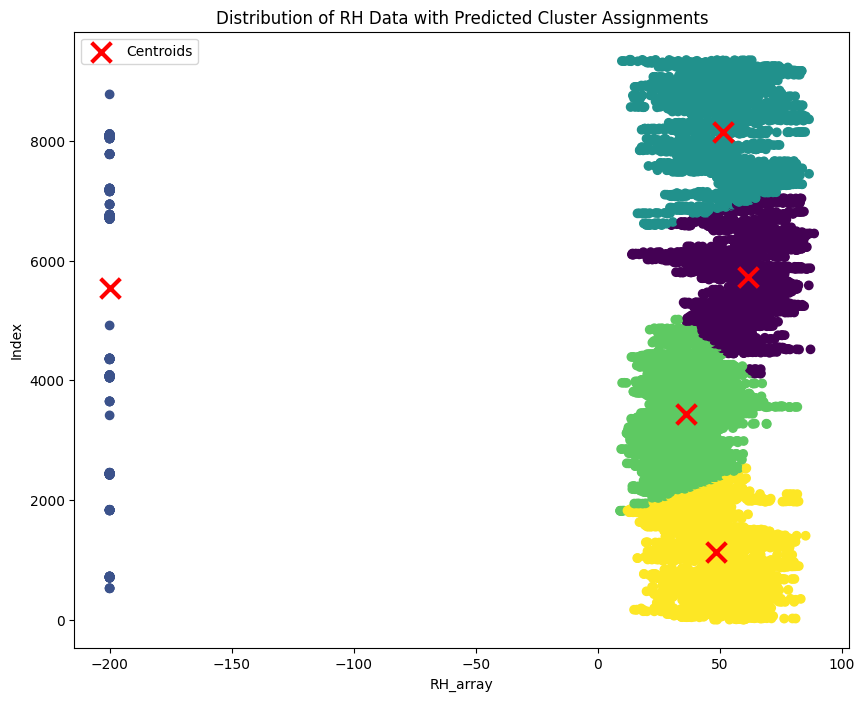

In [26]:
# Option 1: Create 2D visualization from 1D data
import numpy as np
from sklearn.preprocessing import StandardScaler

# Reshape data to 2D by adding an index dimension
X_2d = np.column_stack((RH_array, np.arange(len(RH_array))))

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_2d)

# Create and fit the model
clt = KMeans_AIR(K=5, n_init=20, max_iters=300)
clt.fit(X_scaled)

# Get predictions and centroids
y_pred = clt.predict(X_scaled)
centers_pred = clt.return_centroids()

# Inverse transform the centroids for plotting
centers_pred_original = scaler.inverse_transform(centers_pred)

# Visualize
plt.figure(figsize=(10,8))
plt.scatter(RH_array, np.arange(len(RH_array)), c=y_pred, cmap='viridis')
plt.scatter(centers_pred_original[:,0], centers_pred_original[:,1], 
           c='red', marker='x', s=200, linewidth=3, label='Centroids')
plt.xlabel('RH_array')
plt.ylabel('Index')
plt.title('Distribution of RH Data with Predicted Cluster Assignments')
plt.legend()
plt.show()

Starting training with 20 initializations...
Initialization 1/20: Converged at iteration 3
Initialization 1/20: WCSS = 0.00
Initialization 2/20: Converged at iteration 3
Initialization 2/20: WCSS = 0.00
Initialization 3/20: Converged at iteration 3
Initialization 3/20: WCSS = 0.00
Initialization 4/20: Converged at iteration 6
Initialization 4/20: WCSS = 0.00
Initialization 5/20: Converged at iteration 3
Initialization 5/20: WCSS = 0.00
Initialization 6/20: Converged at iteration 5
Initialization 6/20: WCSS = 0.00
Initialization 7/20: Converged at iteration 3
Initialization 7/20: WCSS = 0.00
Initialization 8/20: Converged at iteration 6
Initialization 8/20: WCSS = 0.00
Initialization 9/20: Converged at iteration 6
Initialization 9/20: WCSS = 0.00
Initialization 10/20: Converged at iteration 5
Initialization 10/20: WCSS = 0.00
Initialization 11/20: Converged at iteration 2
Initialization 11/20: WCSS = 1871.50
Initialization 12/20: Converged at iteration 2
Initialization 12/20: WCSS = 187

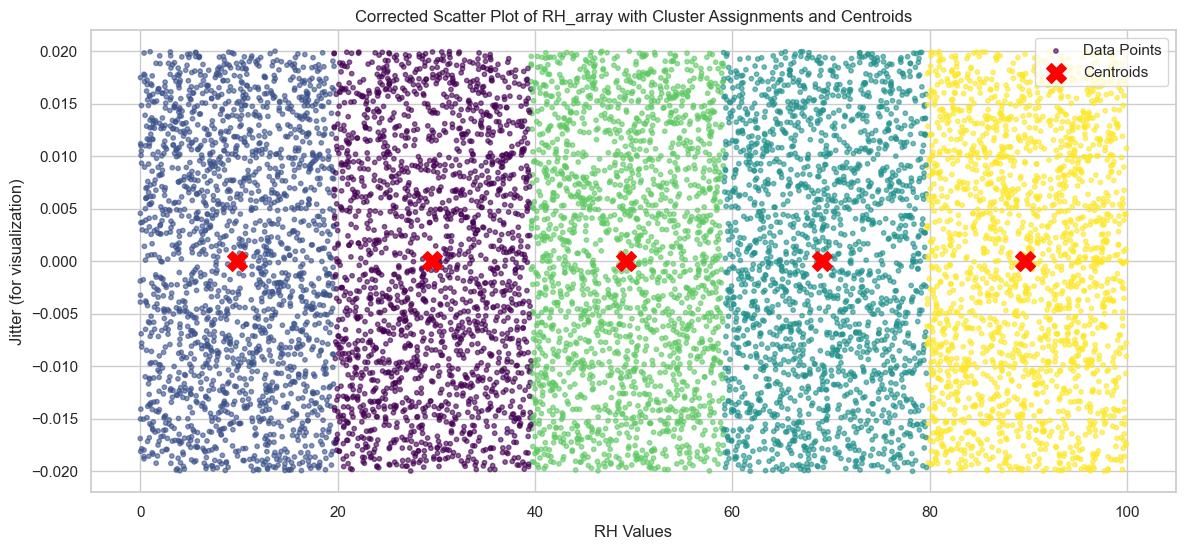


Evaluation Metrics:
Mean Absolute Error (MAE): 0.0000
Accuracy: 1.0000
Precision Score: 1.0000
Recall Score: 1.0000
F1 Score: 1.0000


In [33]:
import numpy as np
from typing import Tuple, Dict
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Your KMeans_AIR Class
# =========================
class KMeans_AIR(object):
    def __init__(self, K: int=5, n_init: int=20, max_iters: int=300) -> None:
        if K <= 0:
            raise ValueError(f'K must be a positive integer, got: {K}')
        if n_init <= 0:
            raise ValueError(f'n_init must be a positive integer, got: {n_init}')
        if max_iters <= 0:
            raise ValueError(f'Input argument max_iters must be a positive integer, got: {max_iters}')
        
        self.K = K
        self.n_init = n_init
        self.centroids = np.array([])
        self.total_wcss = np.inf
        self.wcss_array = np.array([])
        self.max_iters = max_iters
        
    def __assign_samples(self, X: np.array, centroids: np.array) -> np.array:
        differences = X[:, np.newaxis, :] - centroids[np.newaxis, :, :]
        euclid_dist = np.einsum('ijk,ijk->ij', differences, differences)
        return np.argmin(euclid_dist, axis=1)

    def __partition_data(self, X: np.array, cluster_assignment: np.array) -> list:
        clusters = []
        for k in range(self.K):
            mask = cluster_assignment == k
            cluster_points = X[mask]
            clusters.append(cluster_points)
        return clusters
    
    def __compute_wcss(self, X: np.array, cluster_assignment: np.array, centroids: np.array) -> Tuple[float, np.array]:
        wcss_array = np.zeros(self.K)
        for k in range(self.K):
            mask = cluster_assignment == k
            if np.sum(mask) > 0:
                cluster_points = X[mask]
                wcss_array[k] = np.sum((cluster_points - centroids[k]) ** 2)
        return np.sum(wcss_array), wcss_array
        
    def __update_centroids(self, X: np.array, cluster_assignment: np.array) -> np.array:
        new_centroids = np.zeros((self.K, X.shape[1]))
        for k in range(self.K):
            mask = cluster_assignment == k
            if np.sum(mask) > 0:
                new_centroids[k] = np.mean(X[mask], axis=0)
            else:
                new_centroids[k] = X[np.random.choice(X.shape[0])]
        return new_centroids

    def fit(self, X: np.array) -> None:
        print(f"Starting training with {self.n_init} initializations...")
        self.total_wcss = np.inf
        best_centroids = None
        
        for init in range(self.n_init):
            centroids = X[np.random.choice(X.shape[0], self.K, replace=False)]
            old_centroids = np.copy(centroids)
            
            for iteration in range(self.max_iters):
                cluster_assignment = self.__assign_samples(X, centroids)
                centroids = self.__update_centroids(X, cluster_assignment)
                
                if np.allclose(old_centroids, centroids):
                    print(f"Initialization {init + 1}/{self.n_init}: Converged at iteration {iteration + 1}")
                    break
                old_centroids = np.copy(centroids)
            
            total_wcss, wcss_array = self.__compute_wcss(X, cluster_assignment, centroids)
            print(f"Initialization {init + 1}/{self.n_init}: WCSS = {total_wcss:.2f}")
            
            if total_wcss < self.total_wcss:
                self.total_wcss = total_wcss
                self.wcss_array = wcss_array
                self.centroids = centroids
                
        if self.centroids.size == 0:
            raise Exception("Failed to find valid clustering solution!")
        
        print(f"Training completed. Final WCSS: {self.total_wcss:.2f}")
                
    def predict(self, X: np.array) -> np.array:
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.__assign_samples(X, self.centroids)
        
    def return_wcss(self) -> Tuple[float, np.array]:
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return (self.total_wcss, self.wcss_array)
        
    def return_centroids(self) -> np.array:
        if self.centroids.size == 0:
            raise Exception("It doesn't look like you have trained this model yet!")
        return self.centroids
        
    def get_params(self, deep: bool = False) -> Dict:
        return {
            'K': self.K, 
            'n_init': self.n_init, 
            'max_iters': self.max_iters
        }

# =========================
# Data Preparation
# =========================

# Replace the synthetic data with your actual RH_array
# For demonstration, we'll create a synthetic RH_array similar to yours
np.random.seed(42)  # For reproducibility
RH_array = np.random.uniform(low=0.0, high=100.0, size=(9357, 1))  # Replace with your actual data

# Flatten the array to shape (9357,) for easier processing
RH_flat = RH_array.flatten()

# Step 1: Define quintiles (20%, 40%, 60%, 80%) to split the data into 5 sections
quantiles = np.percentile(RH_flat, [20, 40, 60, 80])

# Function to assign quantile labels
def assign_quantiles(data, quantiles):
    labels = np.zeros(data.shape[0], dtype=int)
    labels[data > quantiles[3]] = 4  # Q5
    labels[(data > quantiles[2]) & (data <= quantiles[3])] = 3  # Q4
    labels[(data > quantiles[1]) & (data <= quantiles[2])] = 2  # Q3
    labels[(data > quantiles[0]) & (data <= quantiles[1])] = 1  # Q2
    labels[data <= quantiles[0]] = 0  # Q1
    return labels

# Assign labels based on quantiles
y = assign_quantiles(RH_flat, quantiles)

# Step 2: Create one-hot encoded features based on quantile labels
X = np.zeros((RH_flat.shape[0], 5))
X[np.arange(RH_flat.shape[0]), y] = 1

# =========================
# K-Means Clustering
# =========================

# Initialize and fit the KMeans_AIR model
kmeans = KMeans_AIR(K=5, n_init=20, max_iters=300)
kmeans.fit(X)

# Predict cluster assignments
cluster_labels = kmeans.predict(X)

# =========================
# Corrected Scatter Plot with Centroids
# =========================

# Step 1: Calculate Centroids in RH Value Space
centroid_values = []
for cluster in np.unique(cluster_labels):
    points_in_cluster = RH_flat[cluster_labels == cluster]
    if len(points_in_cluster) > 0:
        centroid_value = np.mean(points_in_cluster)  # Take the mean of RH values in this cluster
        centroid_values.append(centroid_value)
    else:
        centroid_values.append(np.nan)  # Handle empty clusters (if any)

# Convert the centroids list to a NumPy array for easy plotting
centroid_values = np.array(centroid_values)

# Step 2: Scatter Plot with Correct Centroid Positions
plt.figure(figsize=(14, 6))

# Add jitter to y-axis for better visualization of points
jitter_strength = 0.02
y_jitter = np.random.uniform(-jitter_strength, jitter_strength, size=RH_flat.shape[0])

# Scatter plot of RH values colored by cluster assignments
scatter = plt.scatter(RH_flat, y_jitter, c=cluster_labels, cmap='viridis', alpha=0.6, s=10, label='Data Points')

# Plot centroids on the x-axis (with y=0 for centroids)
plt.scatter(centroid_values, np.zeros_like(centroid_values), c='red', marker='X', s=200, label='Centroids')

# Add labels and title
plt.title('Corrected Scatter Plot of RH_array with Cluster Assignments and Centroids')
plt.xlabel('RH Values')
plt.ylabel('Jitter (for visualization)')
plt.legend(loc='upper right')

# Display the plot
plt.show()

# =========================
# Evaluation Metrics
# =========================

# Map clusters to quantile labels using Hungarian algorithm for optimal assignment
def map_clusters_to_labels(y_true, y_clusters):
    contingency_matrix = np.zeros((5, 5), dtype=int)
    for true_label in range(5):
        for cluster_label in range(5):
            contingency_matrix[true_label, cluster_label] = np.sum((y_true == true_label) & (y_clusters == cluster_label))
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    mapping = {cluster_label: true_label for true_label, cluster_label in zip(row_ind, col_ind)}
    mapped_labels = np.vectorize(mapping.get)(y_clusters)
    return mapped_labels

# Map cluster labels to true labels
y_mapped = map_clusters_to_labels(y, cluster_labels)

# Calculate evaluation metrics
mae = mean_absolute_error(y, y_mapped)
accuracy = accuracy_score(y, y_mapped)
precision = precision_score(y, y_mapped, average='weighted', zero_division=0)
recall = recall_score(y, y_mapped, average='weighted', zero_division=0)
f1 = f1_score(y, y_mapped, average='weighted', zero_division=0)

print("\nEvaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision Score: {precision:.4f}")
print(f"Recall Score: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
